Ep 031 | Loss: 471.68 | Reward: -261.58 | MA(50): -167.80
Ep 032 | Loss: 828.07 | Reward: -100.64 | MA(50): -165.76
Ep 033 | Loss: 455.01 | Reward: -144.18 | MA(50): -165.13
Ep 034 | Loss: 402.08 | Reward: -99.14 | MA(50): -163.24
Ep 035 | Loss: 779.72 | Reward: -354.91 | MA(50): -168.56
Ep 036 | Loss: 515.51 | Reward: -309.71 | MA(50): -172.38
Ep 037 | Loss: 966.04 | Reward: -330.70 | MA(50): -176.55
Ep 038 | Loss: 764.31 | Reward: -304.31 | MA(50): -179.82
Ep 039 | Loss: 623.99 | Reward: -126.20 | MA(50): -178.48
Ep 040 | Loss: 697.74 | Reward: -623.06 | MA(50): -189.32
[Track] Last10 Reward Avg: -265.44
Ep 041 | Loss: 1065.12 | Reward: -882.64 | MA(50): -205.83
Ep 042 | Loss: 951.21 | Reward: -663.00 | MA(50): -216.46
Ep 043 | Loss: 1004.63 | Reward: -909.52 | MA(50): -232.22
Ep 044 | Loss: 582.84 | Reward: -862.96 | MA(50): -246.23
Ep 045 | Loss: 1974.12 | Reward: -593.41 | MA(50): -253.78
Ep 046 | Loss: 1185.75 | Reward: -601.31 | MA(50): -261.17
Ep 047 | Loss: 844.10 | Reward: -1

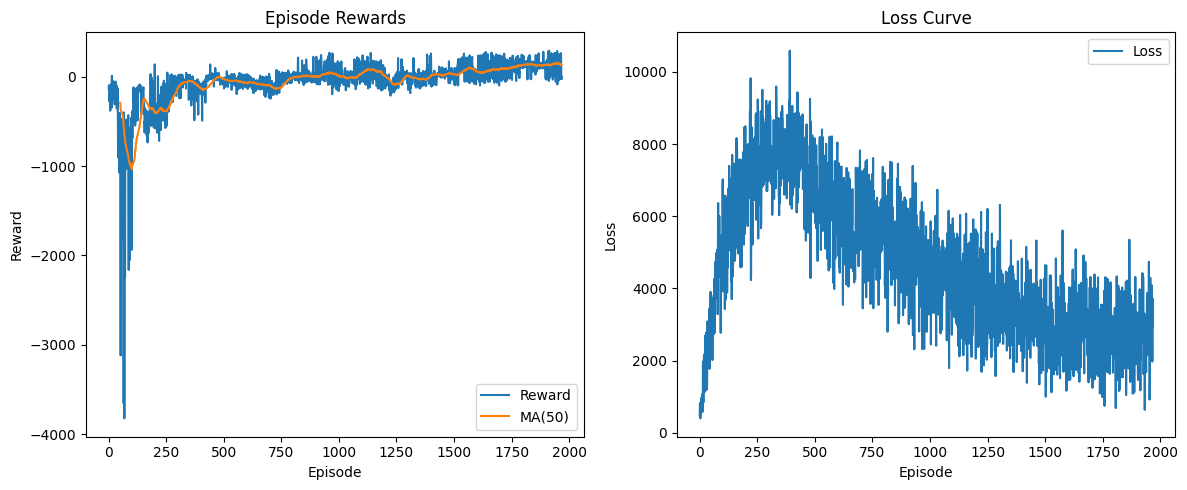

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import imageio
import os

# Hyperparameters
ENV_NAME = "LunarLander-v3"
EPISODES = 2000
GAMMA = 0.99
TAU = 0.05  # reduced entropy weight
K = 2
LR = 3e-4
MAX_STEPS = 500
REPLAY_SIZE = 10000
BATCH_SIZE = 32
EVAL_INTERVAL = 50
GRAD_CLIP = 0.3
GIF_SAVE_PATH = "D:/Coding Projects/Reinforcement Learning/lander_demo_final.gif"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        logits = self.model(x)
        log_probs = F.log_softmax(logits, dim=-1)
        probs = F.softmax(logits, dim=-1)
        return log_probs, probs

class ValueNet(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)

class TrajectoryReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, trajectory):
        self.buffer.append(trajectory)

    def sample(self, batch_size, k):
        samples = []
        for _ in range(batch_size):
            traj = random.choice(self.buffer)
            if len(traj) > k:
                t = random.randint(0, len(traj) - k - 1)
                samples.append(traj[t:t + k + 1])
        return samples

    def __len__(self):
        return len(self.buffer)

def collect_trajectory(env, policy_net):
    traj = []
    obs, _ = env.reset()
    for _ in range(MAX_STEPS):
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        log_probs, probs = policy_net(obs_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample().item()

        next_obs, reward, terminated, truncated, _ = env.step(action)
        traj.append((obs, action, reward, next_obs))

        if terminated or truncated:
            break
        obs = next_obs
    return traj

def evaluate_policy(env, policy_net, episodes=5):
    policy_net.eval()
    total_reward = 0
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            _, probs = policy_net(obs_tensor)
            action = torch.argmax(probs, dim=1).item()
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated
        total_reward += episode_reward
    avg_reward = total_reward / episodes
    print(f"[Eval] Avg Reward over {episodes} episodes: {avg_reward:.2f}")
    policy_net.train()

def generate_gif(policy_net):
    env = gym.make(ENV_NAME, render_mode="rgb_array")
    obs, _ = env.reset()
    frames = []
    for _ in range(MAX_STEPS):
        frame = env.render()
        frames.append(frame)
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        with torch.no_grad():
            _, probs = policy_net(obs_tensor)
        action = torch.argmax(probs, dim=1).item()
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    imageio.mimsave(GIF_SAVE_PATH, frames, duration=1/30)
    print(f"✅ GIF saved as '{GIF_SAVE_PATH}'")

def plot_metrics(reward_history, loss_history):
    min_len = min(len(reward_history), len(loss_history))
    reward_history = reward_history[:min_len]
    loss_history = loss_history[:min_len]
    episodes = np.arange(min_len)
    ma50 = np.convolve(reward_history, np.ones(50)/50, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, reward_history, label="Reward")
    plt.plot(np.arange(49, len(ma50)+49), ma50, label="MA(50)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.title("Episode Rewards")

    plt.subplot(1, 2, 2)
    plt.plot(episodes, loss_history, label="Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    print("📈 Training plot saved as 'training_metrics.png'")
    plt.show()

def train():
    env = gym.make(ENV_NAME)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = PolicyNet(state_dim, action_dim).to(device)
    value_net = ValueNet(state_dim).to(device)

    optimizer = optim.AdamW(list(policy_net.parameters()) + list(value_net.parameters()), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.97)
    buffer = TrajectoryReplayBuffer(REPLAY_SIZE)
    reward_history = []
    loss_history = []

    for episode in range(EPISODES):
        entropy_coeff = max(0.01, TAU * (0.995 ** episode))
        traj = collect_trajectory(env, policy_net)
        buffer.push(traj)
        episode_reward = sum([step[2] for step in traj])
        reward_history.append(episode_reward)

        if len(buffer) < BATCH_SIZE:
            continue

        batch = buffer.sample(BATCH_SIZE, K)
        total_loss = 0

        for path in batch:
            R, log_pi_sum = 0, 0
            for i in range(K):
                s_i, a_i, r_i, _ = path[i]
                R += (GAMMA ** i) * r_i
                s_i_tensor = torch.FloatTensor(s_i).unsqueeze(0).to(device)
                log_probs, _ = policy_net(s_i_tensor)
                clipped_log_prob = torch.clamp(log_probs[0, a_i], min=-20, max=0)
                log_pi_sum += clipped_log_prob

            s_t = torch.FloatTensor(path[0][0]).unsqueeze(0).to(device)
            s_tk = torch.FloatTensor(path[K][0]).unsqueeze(0).to(device)
            V_s_t = value_net(s_t)
            V_s_tk = torch.clamp(value_net(s_tk).detach(), min=-500, max=500)

            delta = R + (GAMMA ** K) * V_s_tk - V_s_t - entropy_coeff * log_pi_sum
            delta = torch.clamp(delta, min=-20, max=20)
            loss = delta.pow(2).mean()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(policy_net.parameters()) + list(value_net.parameters()), GRAD_CLIP)
            optimizer.step()
            total_loss += loss.item()

        loss_history.append(total_loss)
        scheduler.step()
        avg_reward = sum(reward_history[-50:]) / min(len(reward_history), 50)
        print(f"Ep {episode:03d} | Loss: {total_loss:.2f} | Reward: {episode_reward:.2f} | MA(50): {avg_reward:.2f}")

        if episode % 10 == 0:
            print(f"[Track] Last10 Reward Avg: {np.mean(reward_history[-10:]):.2f}")
        if episode % EVAL_INTERVAL == 0:
            evaluate_policy(env, policy_net)

    torch.save(policy_net.state_dict(), "pcl_policy_lunarlander.pt")
    torch.save(value_net.state_dict(), "pcl_value_lunarlander.pt")
    print("✅ Models saved as 'pcl_policy_lunarlander.pt' and 'pcl_value_lunarlander.pt'")
    env.close()

    if any(np.mean(reward_history[i:i+10]) > 200 for i in range(len(reward_history) - 10)):
        print("🎉 Problem Solved: Agent consistently lands the Lunar Lander!")
    else:
        print("⚠️ Not yet solved: Keep training or tune hyperparameters.")

    generate_gif(policy_net)
    plot_metrics(reward_history, loss_history)

if __name__ == "__main__":
    train()


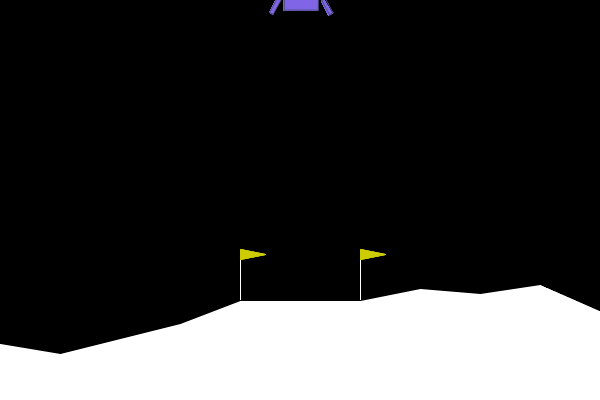

In [5]:
from IPython.display import Image

# Provide the path to your GIF file
file_path = r'D:\Coding Projects\Reinforcement Learning\lander_demo_final.gif'

# Display the GIF
Image(filename=file_path)


OPTIMIZED VERSION:

Ep 233 | Loss: 1265.26 | Reward: -49.97 | MA(50): -190.40
Ep 234 | Loss: 1590.03 | Reward: -112.94 | MA(50): -183.06
Ep 235 | Loss: 1217.65 | Reward: -386.78 | MA(50): -184.96
Ep 236 | Loss: 839.04 | Reward: -292.36 | MA(50): -187.22
Ep 237 | Loss: 1502.62 | Reward: -566.74 | MA(50): -187.04
Ep 238 | Loss: 1968.02 | Reward: -917.12 | MA(50): -196.92
Ep 239 | Loss: 1685.60 | Reward: -606.41 | MA(50): -213.46
Ep 240 | Loss: 966.93 | Reward: -730.38 | MA(50): -222.83
[Track] Last10 Reward Avg: -404.34
Ep 241 | Loss: 1278.18 | Reward: -566.48 | MA(50): -235.86
Ep 242 | Loss: 1153.94 | Reward: -584.14 | MA(50): -240.73
Ep 243 | Loss: 1757.12 | Reward: -702.00 | MA(50): -250.94
Ep 244 | Loss: 1802.67 | Reward: -611.09 | MA(50): -262.67
Ep 245 | Loss: 975.84 | Reward: -488.57 | MA(50): -273.00
Ep 246 | Loss: 1218.34 | Reward: -383.67 | MA(50): -281.13
Ep 247 | Loss: 1221.78 | Reward: -569.82 | MA(50): -288.77
Ep 248 | Loss: 1410.18 | Reward: -819.06 | MA(50): -294.02
Ep 249 | Loss: 2108.68 | 

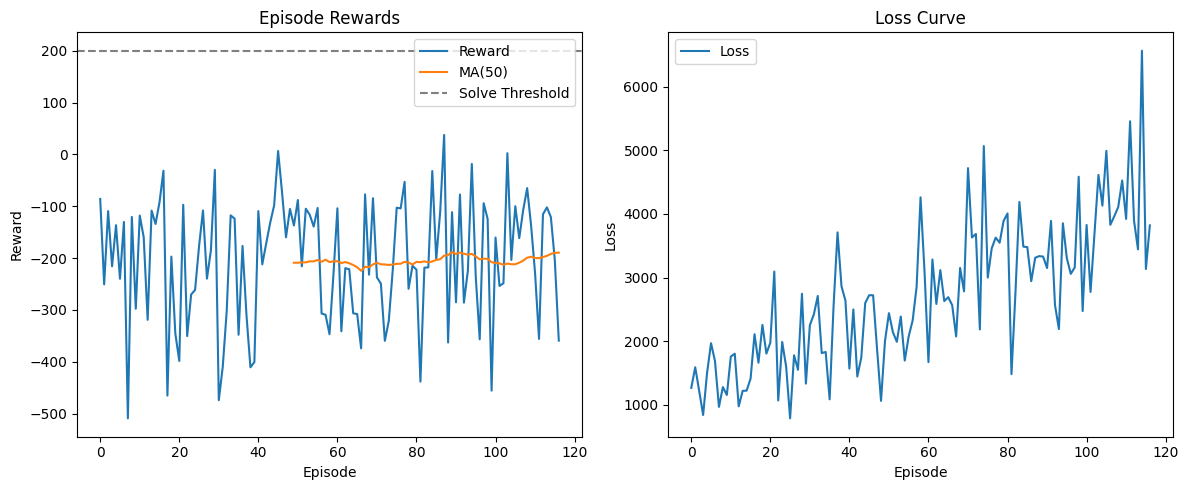

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import imageio
import os

# Hyperparameters
ENV_NAME = "LunarLander-v3"

EPISODES = 2000
GAMMA = 0.99
TAU = 0.05  # reduced entropy weight
K = 2
LR = 3e-4


MAX_STEPS = 500
REPLAY_SIZE = 10000
BATCH_SIZE = 64
EVAL_INTERVAL = 50
GRAD_CLIP = 1.0
GIF_SAVE_PATH = "D:/Coding Projects/Reinforcement Learning/lander_demo_final_optimized_2.gif"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        logits = self.model(x)
        log_probs = F.log_softmax(logits, dim=-1)
        probs = F.softmax(logits, dim=-1)
        return log_probs, probs

class ValueNet(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)

class TrajectoryReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, trajectory):
        total_reward = sum([step[2] for step in trajectory])
        if total_reward > 0 or random.random() < 0.3:  # filter failed episodes
            self.buffer.append(trajectory)

    def sample(self, batch_size, k):
        samples = []
        for _ in range(batch_size):
            traj = random.choice(self.buffer)
            if len(traj) > k:
                t = random.randint(0, len(traj) - k - 1)
                samples.append(traj[t:t + k + 1])
        return samples

    def __len__(self):
        return len(self.buffer)

def collect_trajectory(env, policy_net):
    traj = []
    obs, _ = env.reset()
    for _ in range(MAX_STEPS):
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        log_probs, probs = policy_net(obs_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample().item()

        next_obs, reward, terminated, truncated, _ = env.step(action)

        # reward shaping
        if next_obs[1] > obs[1]:  # moved up
            reward += 0.05
        if abs(next_obs[4]) < 0.1:  # small angle tilt
            reward += 0.1

        traj.append((obs, action, reward, next_obs))

        if terminated or truncated:
            break
        obs = next_obs
    return traj

def evaluate_policy(env, policy_net, episodes=5):
    policy_net.eval()
    total_reward = 0
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            _, probs = policy_net(obs_tensor)
            action = torch.argmax(probs, dim=1).item()
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated
        total_reward += episode_reward
    avg_reward = total_reward / episodes
    print(f"[Eval] Avg Reward over {episodes} episodes: {avg_reward:.2f}")
    policy_net.train()

def generate_gif(policy_net):
    env = gym.make(ENV_NAME, render_mode="rgb_array")
    obs, _ = env.reset()
    frames = []
    for _ in range(MAX_STEPS):
        frame = env.render()
        frames.append(frame)
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        with torch.no_grad():
            _, probs = policy_net(obs_tensor)
        action = torch.argmax(probs, dim=1).item()
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    imageio.mimsave(GIF_SAVE_PATH, frames, duration=1/30)
    print(f"✅ GIF saved as '{GIF_SAVE_PATH}'")

def plot_metrics(reward_history, loss_history):
    min_len = min(len(reward_history), len(loss_history))
    reward_history = reward_history[:min_len]
    loss_history = loss_history[:min_len]
    episodes = np.arange(min_len)

    plt.figure(figsize=(12, 5))
    
    # Reward Plot
    plt.subplot(1, 2, 1)
    plt.plot(episodes, reward_history, label="Reward")
    if len(reward_history) >= 50:
        ma50 = np.convolve(reward_history, np.ones(50)/50, mode='valid')
        plt.plot(np.arange(49, len(ma50)+49), ma50, label="MA(50)")
    plt.axhline(200, color="gray", linestyle="--", label="Solve Threshold")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.title("Episode Rewards")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(episodes, loss_history, label="Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    print("📈 Training plot saved as 'training_metrics.png'")
    plt.show()


def train():
    env = gym.make(ENV_NAME)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = PolicyNet(state_dim, action_dim).to(device)
    value_net = ValueNet(state_dim).to(device)

    optimizer = optim.AdamW(list(policy_net.parameters()) + list(value_net.parameters()), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.97)
    buffer = TrajectoryReplayBuffer(REPLAY_SIZE)
    reward_history = []
    loss_history = []

    for episode in range(EPISODES):
        ## Compute recent moving average reward
        if len(reward_history) == 0:
            avg_reward = 0
        else:
            avg_reward = sum(reward_history[-50:]) / min(len(reward_history), 50)

        # Dynamic entropy decay + performance-aware override
        if avg_reward > 150:
            entropy_coeff = 0.001  # reduce exploration aggressively
        elif episode < 500:
            entropy_coeff = max(0.01, TAU * (0.99 ** episode))
        else:
            entropy_coeff = 0.01

        traj = collect_trajectory(env, policy_net)
        buffer.push(traj)
        episode_reward = sum([step[2] for step in traj])
        reward_history.append(episode_reward)

        if len(buffer) < BATCH_SIZE:
            continue

        batch = buffer.sample(BATCH_SIZE, K)
        total_loss = 0

        for path in batch:
            R, log_pi_sum = 0, 0
            for i in range(K):
                s_i, a_i, r_i, _ = path[i]
                R += (GAMMA ** i) * r_i
                s_i_tensor = torch.FloatTensor(s_i).unsqueeze(0).to(device)
                log_probs, _ = policy_net(s_i_tensor)
                clipped_log_prob = torch.clamp(log_probs[0, a_i], min=-20, max=0)
                log_pi_sum += clipped_log_prob

            s_t = torch.FloatTensor(path[0][0]).unsqueeze(0).to(device)
            s_tk = torch.FloatTensor(path[K][0]).unsqueeze(0).to(device)
            V_s_t = value_net(s_t)
            V_s_tk = torch.clamp(value_net(s_tk).detach(), min=-500, max=500)

            delta = R + (GAMMA ** K) * V_s_tk - V_s_t - entropy_coeff * log_pi_sum
            delta = torch.clamp(delta, min=-20, max=20)
            loss = delta.pow(2).mean()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(policy_net.parameters()) + list(value_net.parameters()), GRAD_CLIP)
            optimizer.step()
            total_loss += loss.item()

        loss_history.append(total_loss)
        scheduler.step()
        print(f"Ep {episode:03d} | Loss: {total_loss:.2f} | Reward: {episode_reward:.2f} | MA(50): {avg_reward:.2f}")

        if episode % 10 == 0:
            print(f"[Track] Last10 Reward Avg: {np.mean(reward_history[-10:]):.2f}")
        if episode % EVAL_INTERVAL == 0:
            evaluate_policy(env, policy_net)

         # ✅ EARLY STOPPING CHECK
        avg_reward_check = np.mean(reward_history[-10:])
        if avg_reward_check >= 180:
            print(f"🎉 Converged at Episode {episode} with Last10 Avg: {avg_reward_check:.2f} — stopping early.")
            break


    torch.save(policy_net.state_dict(), "pcl_policy_lunarlander.pt")
    torch.save(value_net.state_dict(), "pcl_value_lunarlander.pt")
    print("✅ Models saved as 'pcl_policy_lunarlander.pt' and 'pcl_value_lunarlander.pt'")
    env.close()

    if any(np.mean(reward_history[i:i+10]) > 200 for i in range(len(reward_history) - 10)):
        print("🎉 Problem Solved: Agent consistently lands the Lunar Lander!")
    else:
        print("⚠️ Not yet solved: Keep training or tune hyperparameters.")

    generate_gif(policy_net)
    plot_metrics(reward_history, loss_history)

if __name__ == "__main__":
    train()


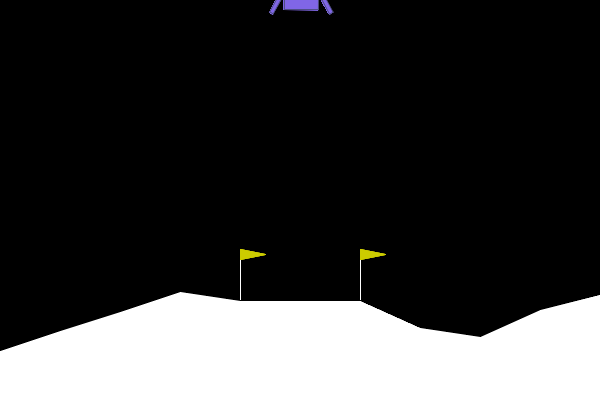

In [18]:
from IPython.display import Image

# Provide the path to your GIF file
file_path = r'D:\Coding Projects\Reinforcement Learning\lander_demo_final_optimized_2.gif'

# Display the GIF
Image(filename=file_path)